In [1]:
# SELECT WHICH FIGURE TO REPRODUCE, then run all cells below to compute & plot
# the labels correspond to settings defined in settings.toml!
# options are: Fig1, Fig2, Fig4, Fig6, Fig7, Fig8
# for reproduction Figures 3 and 5, see the corresponding notebooks
label = "Fig1"

from itertools import product

import numpy as np
from tqdm import tqdm

from schippkus_2023_lib import (
    beamforming,
    compute_synthetic_correlations,
    convert_latlon_to_cartesian,
    define_boundary_sources,
    define_isolated_sources,
    parse_station_coordinates_from_inventory,
    parse_correlations_from_disk,
    select_settings_from_file,
)

# fixed seed for reproduction of results
np.random.seed(42)

settings = select_settings_from_file(label=label)

# Define time
times = np.arange(
    0, settings["timelength"] + 1 / settings["freq"], 1 / settings["freq"]
)
lapsetimes = times - times[-1] / 2

# Define geometry
coordinates, station_coords_sorting = parse_station_coordinates_from_inventory()
settings["station_coords"] = coordinates
settings["station_coords_sorting"] = station_coords_sorting
settings["array_coords_mean"] = np.mean(coordinates, axis=0)
coords_cartesian = convert_latlon_to_cartesian(coordinates)


corr_dirs = [
    "../correlations/whitening/",
    "../correlations/temporal_norm/",
    "../correlations/both/",
    "../correlations/none/",
]

bps_per_processing = []
corrs_per_processing = []
for corr_dir in tqdm(corr_dirs):
    # Correlations
    if settings["type"] == "data":
        corrs = parse_correlations_from_disk(settings, corr_dir=corr_dir)
    elif settings["type"] == "synthetics":
        boundary_sources = define_boundary_sources(settings)
        isolated_sources_per_region = define_isolated_sources(settings)
        corrs = compute_synthetic_correlations(
            boundary_sources, isolated_sources_per_region, settings
        )

    # Define beamforming parameters
    # Pick a reference point to compute traveltimes during beamforming (arbitrary for plane waves)
    settings["reference_point"] = np.mean(coords_cartesian, axis=0)

    # define overlapping time windows to beamform in
    windows = np.arange(
        settings["window_limits"][0],
        settings["window_limits"][1] - settings["window_length"],
        settings["window_length"] * (1 - settings["window_overlap"]),
    )

    # define slowness space in terms of backazimuth and slowness
    azs = np.arange(0, 2 * np.pi, settings["backazimuth_spacing"] * 2 * np.pi / 360)
    slows = np.arange(
        settings["slowness_min"], settings["slowness_max"], settings["slowness_spacing"]
    )
    slowness_space = np.array(
        [(np.cos(az) * s, np.sin(az) * s) for az, s in product(azs, slows)]
    )

    # compute beampowers for each time window
    # output in shape (len(windows), len(slowness_space))
    beampowers_for_time = beamforming(
        data=corrs,
        slowness_space=slowness_space,
        settings=settings,
        lapsetimes=lapsetimes,
        windows=windows,
        coordinates=coords_cartesian,
    )

    bps_per_processing.append(beampowers_for_time)
    corrs_per_processing.append(corrs)

100%|██████████| 4/4 [00:59<00:00, 14.87s/it]


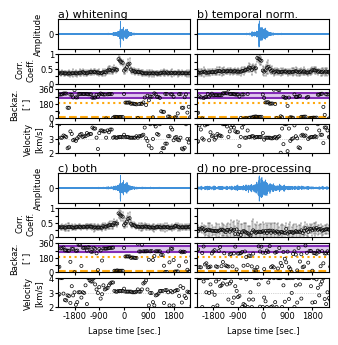

In [3]:
import pylab as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from scipy.signal import iirfilter, zpk2sos, sosfiltfilt
from schippkus_2023_lib import extract_beampower_peaks, compute_correlation_with_beams
from obspy.geodetics import gps2dist_azimuth

plt.style.use("colorblind")

# plotting of results

processing_labels = ["whitening", "temporal norm.", "both", "no pre-processing"]

# colorblind-friendly colormap
cmap = ListedColormap(["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6"])

_cm = 1 / 2.54
fig = plt.figure(figsize=(8.6 * _cm, 8.6 * _cm))
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.95)
outer_grid = GridSpec(2, 2, hspace=0.15, wspace=0.05, figure=fig)
inner_grids = [
    outer_grid[i, j].subgridspec(4, 1, wspace=0, hspace=0.2)
    for i, j in product(range(2), repeat=2)
]
inner_grids_axs = [inner_grid.subplots(sharex=True) for inner_grid in inner_grids]

plt.rc("font", size=6)
plt.rc("axes", titlesize=6)
plt.rc("axes", labelsize=6)
plt.rc("xtick", labelsize=6)
plt.rc("ytick", labelsize=6)

# plt.rc("legend", fontsize=6)
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# initialise map

for axs, processing_label, subplot_id, beampowers_for_time, corrs in zip(
    inner_grids_axs,
    processing_labels,
    ["a)", "b)", "c)", "d)"],
    bps_per_processing,
    corrs_per_processing,
):
    # computations based on results and preparing for plotting

    # filter correlations in the same band as beamformed in
    fn = 0.5 * settings["freq"]
    low = settings["fmin"] / fn
    high = settings["fmax"] / fn
    z, p, k = iirfilter(4, [low, high], btype="band", ftype="butter", output="zpk")
    sos = zpk2sos(z, p, k)
    corrs_filt = sosfiltfilt(sos, corrs, axis=1)

    # Extract beampower peaks from computed beampower distributions
    peaks = extract_beampower_peaks(beampowers_for_time, slows, azs)

    # compute correlation coefficients with best beam for all correlation functions in each window
    corr_coeffs_for_windows = compute_correlation_with_beams(
        windows, peaks, lapsetimes, settings, corrs_filt, coords_cartesian
    )

    ccoeffs_mean = np.mean(corr_coeffs_for_windows, axis=1)
    ccoeffs_std = np.std(corr_coeffs_for_windows, axis=1)

    # sample correlation
    ax = axs[0]
    ax.plot(
        lapsetimes,
        corrs_filt[0] / np.max(np.abs(corrs_filt[0])),
        lw=0.5,
        label=f"{settings['master_station']} - GR.GRA1",
        c=cmap(0),
    )
    ax.set_ylim(-1.1, 1.1)
    ax.set_yticks([0])
    if subplot_id in ["a)", "c)"]:
        ax.set_yticklabels([0], fontsize=6)
        ax.set_ylabel("Amplitude", fontsize=6)
    else:
        ax.set_yticklabels([], fontsize=6)

    ax.set_title(
        f"{subplot_id} {processing_label}", pad=0, loc="left", c="k", fontsize=8
    )

    # ax.legend(loc=0, fontsize=5)

    # correlation coefficients
    ax = axs[1]
    ax.scatter(
        windows + settings["window_length"] / 2,
        ccoeffs_mean,
        s=5,
        fc="None",
        ec="k",
        zorder=2,
        lw=0.5,
    )

    ax.errorbar(
        windows + settings["window_length"] / 2,
        ccoeffs_mean,
        ecolor="#222",
        yerr=ccoeffs_std,
        capsize=1,
        elinewidth=0.25,
        capthick=0.25,
        lw=0,
    )

    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1 + 0.25, 0.25))

    if subplot_id in ["a)", "c)"]:
        ax.set_yticklabels([0, "", 0.5, "", 1], fontsize=6)
        ax.set_ylabel("Corr.\nCoeff.", fontsize=6)
    else:
        ax.set_yticklabels([], fontsize=6)

    # best-beam backazimuth
    ax = axs[2]
    ax.scatter(
        windows + settings["window_length"] / 2,
        peaks[:, 1] % 360,
        s=5,
        fc="None",
        ec="k",
        zorder=3,
        lw=0.5,
    )

    ax.set_ylim(0, 360)
    ax.set_yticks([0, 90, 180, 270, 360])
    if subplot_id in ["a)", "c)"]:
        ax.set_yticklabels([0, "", 180, "", 360], fontsize=6)
        ax.set_ylabel("Backaz.\n" + r"[$^\circ$]", fontsize=6)
    else:
        ax.set_yticklabels([], fontsize=6)

    # mark directions for converging/diverging wavefield contribution
    master_station_coords_baz = gps2dist_azimuth(
        *settings["master_station_coords"][::-1], *settings["array_coords_mean"][::-1]
    )[2]
    converging_az = (master_station_coords_baz % 360) % 180
    diverging_az = (master_station_coords_baz % 180) + 180
    if label == "Fig2":
        converging_az, diverging_az = diverging_az, converging_az
    ax.axhline(converging_az, c=cmap(1), ls="--", label="converging", zorder=2)
    ax.axhline(diverging_az, c=cmap(1), ls=":", label="diverging", zorder=2)

    # mark directions for isolated noise sources
    if settings["type"] == "data":
        ax.plot(
            [windows[0], windows[-1]],
            [300 - 50, 300 - 50],
            c=cmap(4),
            ls="-",
            label="other",
            zorder=1,
        )
        ax.plot(
            [windows[0], windows[-1]], [300 + 20, 300 + 20], c=cmap(4), ls="-", zorder=1
        )

        ax.fill_between(
            [windows[0], windows[-1]], y1=300 - 50, y2=300 + 20, fc=cmap(4), alpha=0.25
        )

    elif settings["type"] == "synthetics":
        for center_lat, center_lon, ls in zip(
            settings["center_lats"], settings["center_lons"], [":", "--"]
        ):
            isolated_source_baz = gps2dist_azimuth(
                center_lat, center_lon, *settings["array_coords_mean"][::-1]
            )[2]
            ax.axhline(
                isolated_source_baz % 360,
                c=cmap(4),
                ls=ls,
                label="isol. source",
                zorder=1,
            )

    # ax.legend(
    #     loc="upper left",
    #     fontsize=6,
    #     bbox_to_anchor=(1, 1.15),
    #     title="directions",
    #     title_fontsize=6,
    #     frameon=False,
    # )

    # best-beam velocity
    ax = axs[3]
    ax.scatter(
        windows + settings["window_length"] / 2,
        peaks[:, 0],
        s=5,
        fc="None",
        ec="k",
        zorder=2,
        lw=0.5,
    )
    ax.set_ylim(2, 4)
    ax.set_yticks([2.0, 3, 4.0])
    ax.axhline(3, lw=0.5, c="#AAAAAA", ls=":", zorder=0)

    if subplot_id in ["c)", "d)"]:
        ax.set_xlabel("Lapse time [sec.]", fontsize=6)
    if subplot_id in ["a)", "c)"]:
        ax.set_yticklabels([2, 3, 4], fontsize=6)
        ax.set_ylabel("Velocity\n" + "[km/s]", fontsize=6)
    else:
        ax.set_yticklabels([], fontsize=6)

    for ax in axs:
        ax.xaxis.set_tick_params(length=2, pad=1)
        ax.yaxis.set_tick_params(length=2, pad=1)
        ax.set_xticks(np.arange(-3600, 3600 + 1, 900))
        if subplot_id in ["c)", "d)"]:
            ax.set_xticklabels(np.arange(-3600, 3600 + 1, 900), fontsize=6)
        else:
            ax.set_xticklabels([])
        ax.set_xlim(-2400, 2400)

    # for ax in axs[:2]:
    #     ax.set_xticklabels([])

fig.savefig(f"../figures/Fig10_processing.pdf", dpi=300)